In [68]:
import pandas as pd
import numpy as np
import re
import random
%matplotlib inline

In [2]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.optimizers import RMSprop
#from keras.utils.data_utils import get_file
import numpy
import random
import sys

Using TensorFlow backend.


ImportError: No module named tensorflow

In [ ]:
#df16 = pd.read_json('http://www.trumptwitterarchive.com/data/2016.json')
#df15 = pd.read_json('http://www.trumptwitterarchive.com/data/2015.json')
#df14 = pd.read_json('http://www.trumptwitterarchive.com/data/2014.json')
#df13 = pd.read_json('http://www.trumptwitterarchive.com/data/2013.json')
#df12 = pd.read_json('http://www.trumptwitterarchive.com/data/2012.json')
#df11 = pd.read_json('http://www.trumptwitterarchive.com/data/2011.json')
#df10 = pd.read_json('http://www.trumptwitterarchive.com/data/2010.json')
#df09 = pd.read_json('http://www.trumptwitterarchive.com/data/2009.json')

In [ ]:
#df = pd.concat([df16, df15, df14, df13, df12, df11, df10, df09], ignore_index=True)
#df = pd.concat([df16, df15, df12], ignore_index=True)

In [ ]:
#df.to_json('trump_12_15_16.json')

In [42]:
df = pd.read_json('trump_12_15_16.json')

In [43]:
df_t = df['text']

In [44]:
ttext = []
for k, v in df_t.iteritems():
    ttext.append(v)

In [45]:
data = ' '.join(ttext)    

In [46]:
tweets = re.sub(r"http\S+",'', data.lower(), flags=re.MULTILINE)

In [47]:
tweets = tweets.encode('ascii', errors='ignore')

In [48]:
def clean(txt):
    txt = txt.replace('\n',' ').replace('{','').replace('}','').replace('|','').replace('~','').replace('&amp','').replace('\"','\'')
    txt = txt.replace('\\','').replace('[','').replace(']','').replace('`','').replace('_',' ').replace('/','').replace('+','')
    txt = txt.replace('*','').replace('=','').replace('\r','')
    txt = txt.replace('SPEECH 1','').replace('SPEECH 2','').replace('SPEECH 3','').replace('SPEECH 4','').replace('SPEECH 5','')
    txt = txt.replace('SPEECH 6','').replace('SPEECH 7','').replace('SPEECH 8','').replace('SPEECH 9','').replace('SPEECH 10','')
    txt = txt.replace('    ',' ').replace('   ',' ').replace('  ',' ')
    return txt

In [49]:
tweets = clean(tweets)

In [50]:
c1 = sorted(list(set(tweets)))

In [51]:
len(c1)

52

In [52]:
#import string
#printable = set(string.printable)
#t2 = filter(lambda x: x in printable, text)

In [53]:
with open('speeches.txt', 'r') as myfile:
    speech=myfile.read().strip().decode('utf-8')

In [54]:
speech = speech.encode('ascii', errors='ignore')

In [55]:
speech_list = speech.split("SPEECH ")

In [56]:
speech_doc = []
for i in speech_list:
    speech_doc.append(clean(i))

In [57]:
speech_doc.pop(0)

''

In [58]:
doc10 = speech_doc.pop(9) + speech_doc.pop(9)

In [59]:
speech_doc_1 = []
count = 0
for d in speech_doc:
    count += 1
    if count == 10:
        speech_doc_1.append(d[2:])
    else:
        speech_doc_1.append(d[1:])

In [60]:
speech = clean(speech)

In [61]:
speech = speech.lower()

In [62]:
c2 = sorted(list(set(speech)))

In [63]:
len(c2)

51

In [64]:
text = clean(tweets + speech)

In [28]:
#f = open("final.txt", "w");
#f.write(text)
#f.close()

In [29]:
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 52
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
#model.add(LSTM(128, input_shape=(maxlen, len(chars))))
#model.add(Dense(len(chars)))
#model.add(Activation('softmax'))

model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

model.summary()

corpus length: 2237658
total chars: 52
nb sequences: 2237606
Vectorization...
Build model...


NameError: name 'Sequential' is not defined

In [185]:
# load the network weights
filename = "weights-improvement-00-1.1278.hdf5"
model.load_weights(filename)
#model.compile(loss='categorical_crossentropy', optimizer='adam')

#optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [186]:
# train the model, output generated text after each iteration
for iteration in range(1, 2):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1, callbacks=callbacks_list)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(140):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
   1536/2237606 [..............................] - ETA: 113557s - loss: 1.2250

KeyboardInterrupt: 

In [83]:
diversity = 0.1

In [84]:
start_index = random.randint(0, len(text) - maxlen - 1)
generated = ''
sentence = text[start_index: start_index + maxlen]
generated += sentence

In [85]:
generated = ''
#sentence = "nce now the norm. nytimes is an example."
sentence = "obamacare is a total catastrophe. itdfdf"

In [86]:
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(generated)

for i in range(140):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.
        
    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

----- Generating with seed: "obamacare is a total catastrophe. itdfdf"
ul the way they want to be the way, its not going to be the way. they want the people want to be the problem that they want to be the money 


In [38]:
generated

' it was a country. you know, its a mariania in the called people are they they were the real fired, other pass the good the it. i think they'

In [54]:
raw_text = text

In [ ]:
# load the network weights
#filename = "weights-improvement-19-1.9435.hdf5"
#model.load_weights(filename)
#model.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
# create mapping of unique chars to integers, and a reverse mapping
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print "Total Characters: ", n_chars
print "Total Vocab: ", n_vocab
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print "Total Patterns: ", n_patterns
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
# load the network weights
filename = "weights-improvement-47-1.2219-bigger.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print "Seed:"
print "\"", ''.join([int_to_char[value] for value in pattern]), "\""
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print "\nDone."

Total Characters:  1369411
Total Vocab:  188
Total Patterns:  1369311


NameError: name 'numpy' is not defined

In [65]:
tweets_doc = clean(df_t)

In [66]:
t_list2 = []
t_list = []
for k, v in df_t.iteritems():
    t_list2.append(re.sub(r"http\S+",'', v.lower(), flags=re.MULTILINE))
for i in t_list2:
    t_list.append(clean(i))

In [67]:
text_list = t_list + speech_doc_1

In [33]:
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models, similarities, matutils

/Users/lemakikuchi/anaconda/lib/python2.7/site-packages/gensim-0.13.3-py2.7-macosx-10.6-x86_64.egg/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [45]:
count_vectorizer = CountVectorizer(analyzer='word',ngram_range=(1, 2), stop_words='english',min_df=1)

In [46]:
count_vectorizer.fit(text_list)

CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [47]:
doc_vecs = count_vectorizer.transform(text_list).transpose()
doc_vecs.shape

(121721, 12843)

In [48]:
count_vectorizer.get_feature_names()

[u'00',
 u'00 00',
 u'00 10',
 u'00 15',
 u'00 30',
 u'00 abc',
 u'00 abc2020',
 u'00 afternoon',
 u'00 american',
 u'00 best',
 u'00 big',
 u'00 capitol',
 u'00 celebapprentice',
 u'00 celebrity',
 u'00 clock',
 u'00 cnn',
 u'00 depending',
 u'00 discuss',
 u'00 eastern',
 u'00 enjoy',
 u'00 episodes',
 u'00 figure',
 u'00 fort',
 u'00 fox',
 u'00 foxandfriends',
 u'00 foxnews',
 u'00 great',
 u'00 hottest',
 u'00 im',
 u'00 incredible',
 u'00 interviewed',
 u'00 joan',
 u'00 likewise',
 u'00 live',
 u'00 make',
 u'00 mike',
 u'00 minutes',
 u'00 mon',
 u'00 mondays',
 u'00 morning',
 u'00 movement',
 u'00 new',
 u'00 oan',
 u'00 pm',
 u'00 politicians',
 u'00 ready',
 u'00 really',
 u'00 remember',
 u'00 seanhannity',
 u'00 special',
 u'00 talk',
 u'00 talking',
 u'00 television',
 u'00 thanks',
 u'00 things',
 u'00 today',
 u'00 tough',
 u'00 tremendous',
 u'00 troops',
 u'00 watch',
 u'00 week',
 u'000',
 u'000 00',
 u'000 000',
 u'000 10',
 u'000 100',
 u'000 11',
 u'000 13',
 u'0

In [49]:
corpus = matutils.Sparse2Corpus(doc_vecs)

In [50]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.iteritems())

In [51]:
lda = models.LdaModel(corpus, id2word=id2word, num_topics=8, passes=10, alpha='auto', eta='auto')

In [52]:
lda.print_topics(num_words=10, num_topics=8)

[(0,
  u'0.010*"going" + 0.006*"people" + 0.006*"know" + 0.004*"great" + 0.004*"dont" + 0.004*"im" + 0.003*"said" + 0.003*"want" + 0.003*"theyre" + 0.003*"just"'),
 (1,
  u'0.013*"realdonaldtrump" + 0.011*"great" + 0.007*"trump" + 0.006*"thank" + 0.004*"tonight" + 0.004*"new" + 0.004*"poll" + 0.003*"night" + 0.003*"debate" + 0.003*"foxnews"'),
 (2,
  u'0.005*"realdonaldtrump" + 0.004*"trump" + 0.004*"hillary" + 0.004*"president" + 0.003*"run" + 0.003*"just" + 0.002*"people" + 0.002*"don" + 0.002*"said" + 0.002*"donald"'),
 (3,
  u'0.019*"realdonaldtrump" + 0.016*"trump2016" + 0.013*"makeamericagreatagain" + 0.009*"trump" + 0.007*"thank" + 0.006*"vote" + 0.004*"makeamericagreatagain trump2016" + 0.004*"america" + 0.003*"donald" + 0.003*"jeb"'),
 (4,
  u'0.023*"realdonaldtrump" + 0.014*"trump" + 0.007*"mr" + 0.006*"president" + 0.006*"mr trump" + 0.005*"donald" + 0.004*"donald trump" + 0.003*"thanks" + 0.003*"need" + 0.002*"best"'),
 (5,
  u'0.005*"marco" + 0.005*"realdonaldtrump" + 0.00

In [53]:
sorted(lda.show_topic(0, topn=30), key=lambda x: x[1], reverse=True) [:30]

[(u'going', 0.0097019935638986525),
 (u'people', 0.0061471157590463621),
 (u'know', 0.0057102210696970898),
 (u'great', 0.0039409593042271651),
 (u'dont', 0.0036535931998889081),
 (u'im', 0.003633714675095294),
 (u'said', 0.0032927003509244119),
 (u'want', 0.003221305844083137),
 (u'theyre', 0.003066960926221642),
 (u'just', 0.0030032472288902576),
 (u'like', 0.0029746819015593149),
 (u'country', 0.0025226809833915043),
 (u'think', 0.0024983230983165305),
 (u'make', 0.0023461554883563414),
 (u'right', 0.0022977966174836453),
 (u'thats', 0.002176859965297913),
 (u'say', 0.0021598554696145651),
 (u'look', 0.0018504323763576802),
 (u'america', 0.0017841164459021575),
 (u'trump', 0.0017781056444670397),
 (u'good', 0.0017575891232121277),
 (u'got', 0.0016867648854103849),
 (u'really', 0.0016476588896282101),
 (u'win', 0.001591549516038243),
 (u'money', 0.0015875709059212457),
 (u'lot', 0.001578789671798966),
 (u'way', 0.0015266630552167764),
 (u'mean', 0.0014769663485704951),
 (u'time', 0.0

In [46]:
lda_corpus = lda[corpus]

In [47]:
lda_docs = [doc for doc in lda_corpus]

In [48]:
doc_topics = [[text_list[i],lda_docs[i]] for i in range(len(list_dir))]

NameError: name 'list_dir' is not defined

In [189]:
sentence = "that's changed bc of you. love u! #trump2016' really"

In [1]:
losers  = ["Republicans must stop relying on losers like @KarlRo",
           "@realDonaldTrump The biggest loser in the debate was",
           "DonaldTrump was right about #RosieODonnell. She is a",
           "Despite what the haters and losers like to say, I ne"]

In [2]:
terrible =["I loved beating these two terrible human beings. I w",
           "If crazy @megynkelly didn't cover me so much on her ",
           "If Hillary thinks she can unleash her husband, with ",
           "President Obama was terrible on @60Minutes tonight. "]

In [3]:
dumbest = ["Bryant Gumbel is one of the dumbest racists around -",
           "Really stupid leadership that wants Al Sharpton to h",
           "Hillary Clinton is not qualified to be president bec",
           "after all these years of watching stupidity, we will"]

In [4]:
worst =   ["Bill Clinton is the WORST abuser of woman in U.S. po",
           "President Obama is the worst president in U.S. histo",
           "Mitt Romney is one of the dumbest and worst candidat",
           "ObamaCare is one of the worst political disasters of"]

In [28]:
mediadis =["Megyn Kelly must have had a terrible vacation, she i",
           "Jon Stewart is a joke, not very bright and totally o",
           "@megynkelly recently said that she can't be wooed by",
           "@NYDailyNews but little Mort Zuckerman is franticall"]

In [29]:
obama =   ["We will immediately repeal and replace ObamaCare - a",
           "Obama has done such a poor job as president, you won",
           "Obama has no understanding of how to create jobs or ",
           "Obama is truly a pathetic excuse of a president, can"]

In [30]:
random = losers + terrible + dumbest + worst + mediadis + obama

In [31]:
random

['Republicans must stop relying on losers like @KarlRo',
 '@realDonaldTrump The biggest loser in the debate was',
 'DonaldTrump was right about #RosieODonnell. She is a',
 'Despite what the haters and losers like to say, I ne',
 'I loved beating these two terrible human beings. I w',
 "If crazy @megynkelly didn't cover me so much on her ",
 'If Hillary thinks she can unleash her husband, with ',
 'President Obama was terrible on @60Minutes tonight. ',
 'Bryant Gumbel is one of the dumbest racists around -',
 'Really stupid leadership that wants Al Sharpton to h',
 'Hillary Clinton is not qualified to be president bec',
 'after all these years of watching stupidity, we will',
 'Bill Clinton is the WORST abuser of woman in U.S. po',
 'President Obama is the worst president in U.S. histo',
 'Mitt Romney is one of the dumbest and worst candidat',
 'ObamaCare is one of the worst political disasters of',
 'Megyn Kelly must have had a terrible vacation, she i',
 'Jon Stewart is a joke, not ve

In [24]:
random_doc

['Republicans must stop relying on losers like @KarlRo',
 '@realDonaldTrump The biggest loser in the debate was',
 'DonaldTrump was right about #RosieODonnell. She is a',
 'Despite what the haters and losers like to say, I ne',
 'I loved beating these two terrible human beings. I w',
 "If crazy @megynkelly didn't cover me so much on her ",
 'If Hillary thinks she can unleash her husband, with ',
 'President Obama was terrible on @60Minutes tonight. ',
 'Bryant Gumbel is one of the dumbest racists around -',
 'Really stupid leadership that wants Al Sharpton to h',
 'Hillary Clinton is not qualified to be president bec',
 'after all these years of watching stupidity, we will',
 'Bill Clinton is the WORST abuser of woman in U.S. po',
 'President Obama is the worst president in U.S. histo',
 'Mitt Romney is one of the dumbest and worst candidat',
 'ObamaCare is one of the worst political disasters of',
 'Megyn Kelly must have had a terrible vacation, she i',
 'Jon Stewart is a joke, not ve

In [194]:
sentence = random.choice(losers)

In [196]:
sentence.lower()

'republicans must stop relying on losers like @karlro'

In [36]:
test = 'republicans must stop relying on losers like @karlrove and jeb bush and what do it was a total disaster. not going to be a ticket of the polls. i mean, i mean, well have a country. i dont know'

In [34]:
'republicans must stop relying on losers like @karlrove and jeb bush and what do it was a total disaster. not going to be a ticket of the polls. i mean, i mean, well have a country. i dont know'

'republicans must stop relying on losers like @karlrove and jeb bush and what do it was a total disaster. not going to be a ticket of the polls. i mean, i mean, well have a country. i dont know'

In [39]:
'.'.join(map((lambda x: x[0].upper()+x[1:]), test.replace('. ','.').split('.'))).replace('.', '. ')

'Republicans must stop relying on losers like @karlrove and jeb bush and what do it was a total disaster. Not going to be a ticket of the polls. I mean, i mean, well have a country. I dont know'

In [40]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

/Users/lemakikuchi/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [89]:
#d = path.dirname(__file__)
#trump_mask = np.array(Image.open(path.join(d, "trump_head.jpg")))
trump_mask = np.array(Image.open("trump_hands1.jpg"))

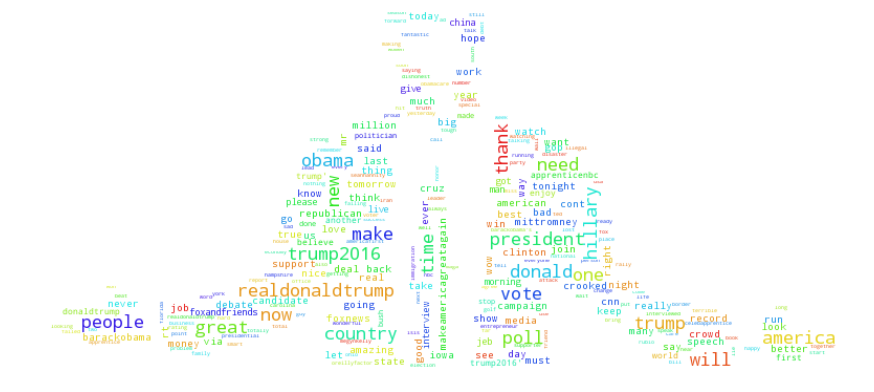

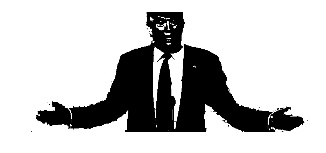

In [105]:
stopwords = set(STOPWORDS)
stopwords.add("even")
stopwords.add("thats")
stopwords.add("lot")

wc = WordCloud(background_color="white", max_words=250, mask=trump_mask,
               stopwords=stopwords)

# generate word cloud
wc.generate(tweets)

# show
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.figure(figsize=(5,5))
plt.imshow(trump_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [99]:
# store to file
wc.to_file("trump_wc2.png")